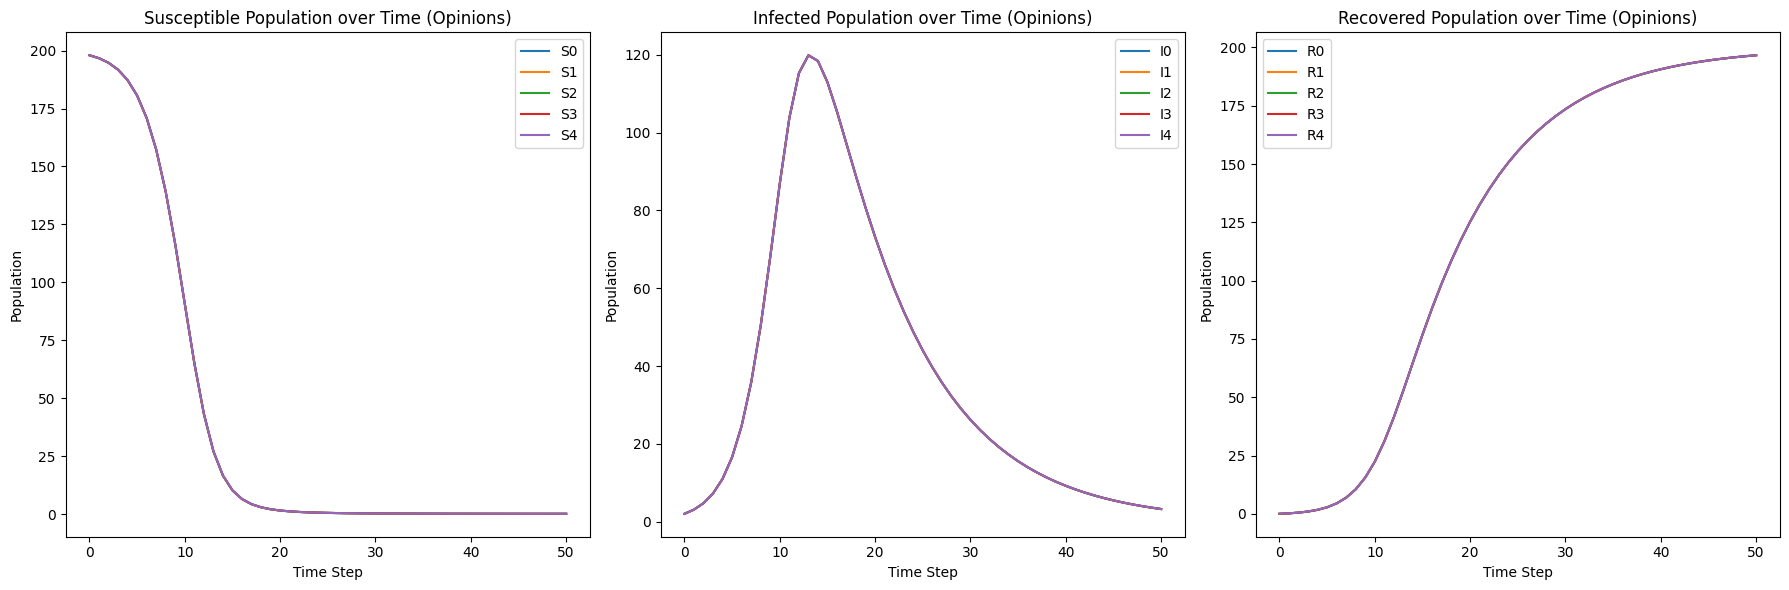

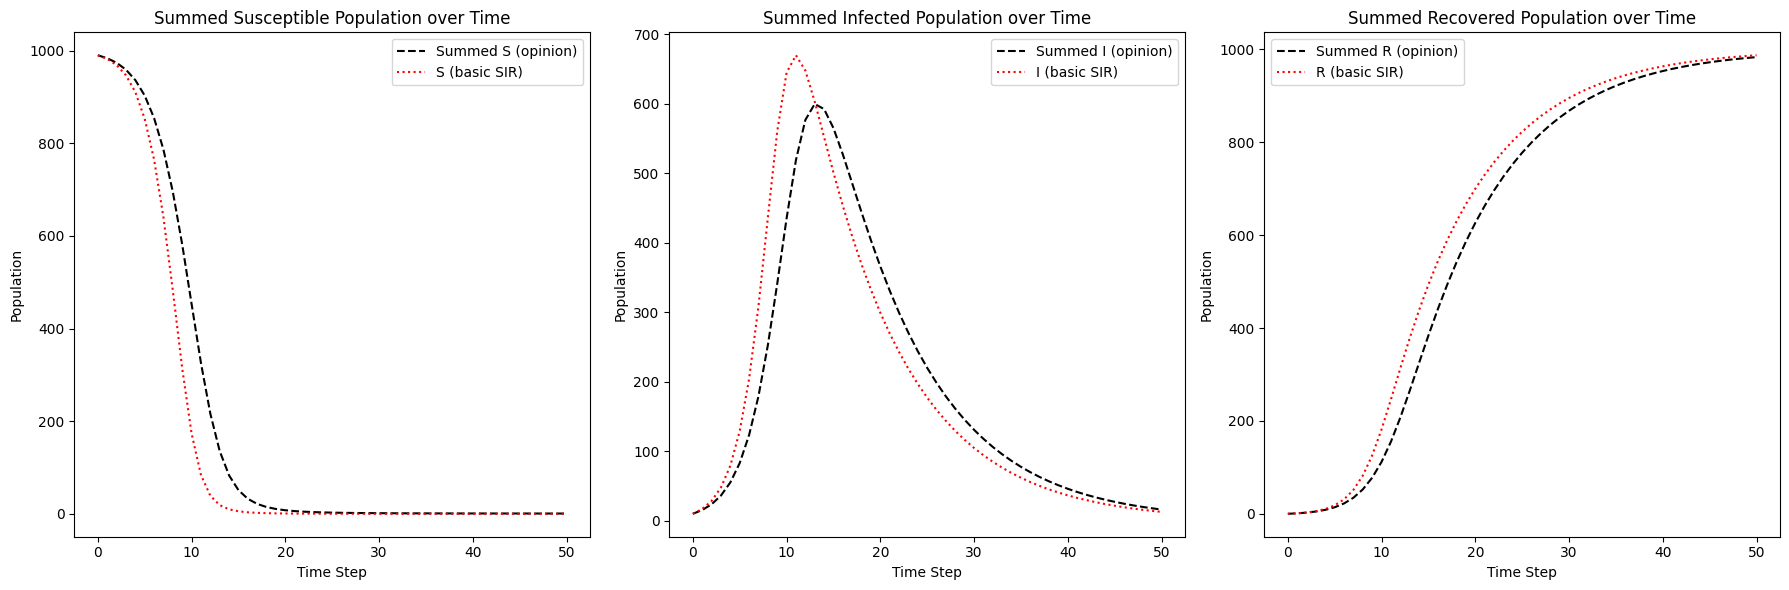

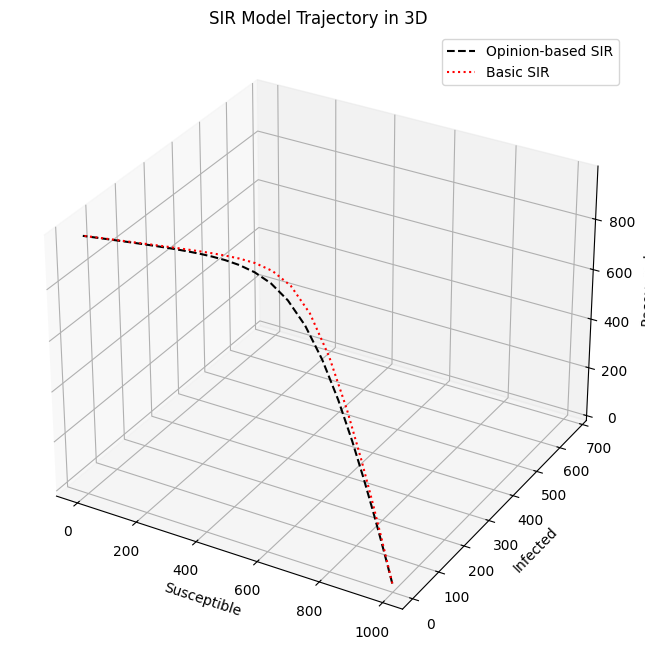

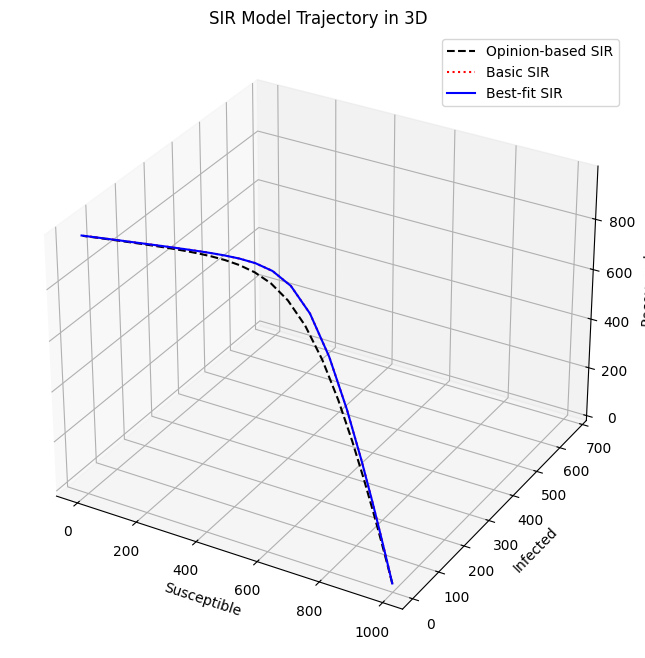

Best fit beta: 0.9885223710423622
Best fit gamma: 0.09999999512979581


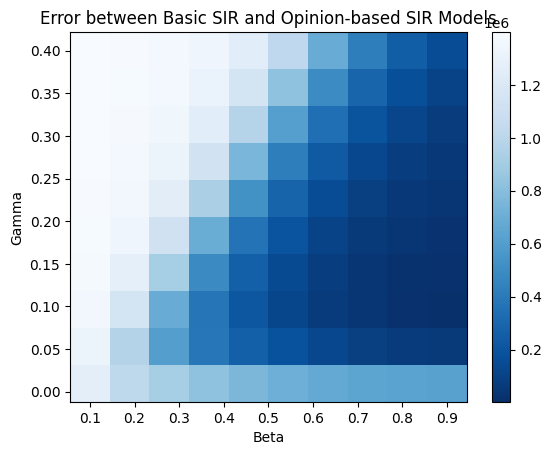

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

def pii(q):
    return 1 / (1 + np.exp(q)), np.exp(q) / (1 + np.exp(q))

def transition_matrix(beta, gamma, statevector, q):
    n = len(q)
    matrix_size = 3 * n
    matrix = np.zeros((matrix_size, matrix_size))

    N = np.sum(statevector)
    ps = statevector[:n] / N
    pi = statevector[n:2*n] / N
    pr = statevector[2*n:3*n] / N

    pii1_vals, pii2_vals = pii(q)

    # Fill the matrix according to the pattern
    for i in range(n):
        for j in range(n):
            # S_i -> S_j
            matrix[i, j] = ps[j] + pi[j] * (pii1_vals[i] * (1-beta) + pii2_vals[i]) + pr[j]
            # S_i -> I_j
            matrix[i, n+j] = pi[j] * pii1_vals[i] * beta
        
        for j in range(n):
            # I_i -> I_j
            matrix[n+i, n+j] = (1-gamma) * (ps[j] + pi[j] + pr[j])
            # I_i -> R_j
            matrix[n+i, 2*n+j] = gamma * (ps[j] + pi[j] + pr[j])
        
        for j in range(n):
            # R_i -> R_j
            matrix[2*n+i, 2*n+j] = ps[j] + pi[j] + pr[j]
    
    return matrix

def simulate_transition(population, beta, gamma, steps, q):
    populations = [np.array(population)]
    for _ in range(steps):
        matrix = transition_matrix(beta, gamma, populations[-1], q)
        population = populations[-1] @ matrix
        populations.append(population)
    return populations

def simulate_basic_SIR(init_state, beta, gamma, steps):
    S, I, R = init_state
    populations = [(S, I, R)]
    N = S + I + R
    
    for _ in range(steps):
        new_S = S - beta * S * I / N
        new_I = I + beta * S * I / N - gamma * I
        new_R = R + gamma * I
        
        S, I, R = new_S, new_I, new_R
        populations.append((S, I, R))
    
    return populations

def plot_results(populations, basic_SIR_populations, n):
    timesteps = len(populations)
    time = np.arange(timesteps)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Sum populations for opinion-based model
    S_total = [sum(pop[:n]) for pop in populations]
    I_total = [sum(pop[n:2*n]) for pop in populations]
    R_total = [sum(pop[2*n:3*n]) for pop in populations]

    axs[0].plot(time, S_total, label='Summed S (opinion)', linestyle='--', color='black')
    axs[1].plot(time, I_total, label='Summed I (opinion)', linestyle='--', color='black')
    axs[2].plot(time, R_total, label='Summed R (opinion)', linestyle='--', color='black')

    # Plot basic SIR model
    basic_S, basic_I, basic_R = zip(*basic_SIR_populations)
    axs[0].plot(time, basic_S, label='S (basic SIR)', linestyle=':', color='red')
    axs[1].plot(time, basic_I, label='I (basic SIR)', linestyle=':', color='red')
    axs[2].plot(time, basic_R, label='R (basic SIR)', linestyle=':', color='red')

    for ax in axs:
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Population')
        ax.legend()

    axs[0].set_title('Summed Susceptible Population over Time')
    axs[1].set_title('Summed Infected Population over Time')
    axs[2].set_title('Summed Recovered Population over Time')

    plt.tight_layout()
    plt.show()

def plot_opinion_results(populations, n):
    timesteps = len(populations)
    time = np.arange(timesteps)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i in range(n):
        S = [pop[i] for pop in populations]
        I = [pop[n+i] for pop in populations]
        R = [pop[2*n+i] for pop in populations]

        axs[0].plot(time, S, label=f'S{i}')
        axs[1].plot(time, I, label=f'I{i}')
        axs[2].plot(time, R, label=f'R{i}')

    for ax in axs:
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Population')
        ax.legend()

    axs[0].set_title('Susceptible Population over Time (Opinions)')
    axs[1].set_title('Infected Population over Time (Opinions)')
    axs[2].set_title('Recovered Population over Time (Opinions)')

    plt.tight_layout()
    plt.show()

def plot_3d_results_2(populations, basic_SIR_populations):
    # Extract populations for opinion-based model
    n = len(populations[0]) // 3
    S_opinion = np.array([sum(pop[:n]) for pop in populations])
    I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
    R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])

    # Extract populations for basic SIR model
    S_basic = np.array([pop[0] for pop in basic_SIR_populations])
    I_basic = np.array([pop[1] for pop in basic_SIR_populations])
    R_basic = np.array([pop[2] for pop in basic_SIR_populations])

    # Plotting the 3D trajectory
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(S_opinion, I_opinion, R_opinion, label='Opinion-based SIR', linestyle='--', color='black')
    ax.plot(S_basic, I_basic, R_basic, label='Basic SIR', linestyle=':', color='red')

    ax.set_xlabel('Susceptible')
    ax.set_ylabel('Infected')
    ax.set_zlabel('Recovered')
    ax.set_title('SIR Model Trajectory in 3D')
    ax.legend()

    plt.show()




def plot_3d_results(populations, basic_SIR_populations, best_fit_populations):
    # Extract populations for opinion-based model
    n = len(populations[0]) // 3
    S_opinion = np.array([sum(pop[:n]) for pop in populations])
    I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
    R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])

    # Extract populations for basic SIR model
    S_basic = np.array([pop[0] for pop in basic_SIR_populations])
    I_basic = np.array([pop[1] for pop in basic_SIR_populations])
    R_basic = np.array([pop[2] for pop in basic_SIR_populations])

    # Extract populations for best-fit SIR model
    S_best_fit = np.array([sum(pop[:n]) for pop in best_fit_populations])
    I_best_fit = np.array([sum(pop[n:2*n]) for pop in best_fit_populations])
    R_best_fit = np.array([sum(pop[2*n:3*n]) for pop in best_fit_populations])

    # Plotting the 3D trajectory
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(S_opinion, I_opinion, R_opinion, label='Opinion-based SIR', linestyle='--', color='black')
    ax.plot(S_basic, I_basic, R_basic, label='Basic SIR', linestyle=':', color='red')
    ax.plot(S_best_fit, I_best_fit, R_best_fit, label='Best-fit SIR', linestyle='-', color='blue')

    ax.set_xlabel('Susceptible')
    ax.set_ylabel('Infected')
    ax.set_zlabel('Recovered')
    ax.set_title('SIR Model Trajectory in 3D')
    ax.legend()

    plt.show()




# Optimization function to fit the parameters
def objective(params, init_state, q, steps, basic_SIR_populations, populations):
    beta, gamma = params
    
    # Simulate the opinion-based SIR model
    populations = simulate_transition(init_opinion_state, beta, gamma, steps, q)
    
    # Sum the opinion-based model results
    S_opinion = np.array([sum(pop[:n]) for pop in populations])
    I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
    R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])
    
    # Extract the basic SIR model results
    S_basic, I_basic, R_basic = zip(*basic_SIR_populations)
    S_basic = np.array(S_basic)
    I_basic = np.array(I_basic)
    R_basic = np.array(R_basic)
    
    # Compute the mean squared error between the opinion-based model and the basic SIR model
    error = np.mean((S_opinion - S_basic)**2 + (I_opinion - I_basic)**2 + (R_opinion - R_basic)**2)
    
    return error

def diff_beta_gamma():
    # Define the range of beta and gamma values for the grid search
    beta_vals = np.linspace(0.1, 0.9, 10)
    gamma_vals = np.linspace(0.01, 0.4, 10)
    errors = np.zeros((len(beta_vals), len(gamma_vals)))

    # Compute the error for each combination of beta and gamma values
    for i, beta_a in enumerate(beta_vals):
        for j, gamma_a in enumerate(gamma_vals):
            
            errors[i, j] = objective([beta_a, gamma_a], init_opinion_state, q, steps, basic_SIR_populations, populations)


    # Plot the error heatmap
    fig, ax = plt.subplots()
    c = ax.pcolormesh(beta_vals, gamma_vals, errors.T, cmap='Blues_r', shading='auto')
    ax.set_xlabel('Beta')
    ax.set_ylabel('Gamma')
    fig.colorbar(c, ax=ax)
    plt.title('Error between Basic SIR and Opinion-based SIR Models')
    plt.show()

def diff_q_values(init_opinion_state, init_state, beta, gamma, steps, q_values, n):
    # Create an empty list to store errors for each q value set
    errors = []
    
    # Iterate over each set of q values
    for q in q_values:
        # Simulate the opinion-based SIR model
        populations = simulate_transition(init_opinion_state, beta, gamma, steps, q)
        
        # Sum the opinion-based model results
        S_opinion = np.array([sum(pop[:n]) for pop in populations])
        I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
        R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])
        
        # Simulate the basic SIR model
        basic_SIR_populations = simulate_basic_SIR(init_state, beta, gamma, steps)
        S_basic, I_basic, R_basic = zip(*basic_SIR_populations)
        S_basic = np.array(S_basic)
        I_basic = np.array(I_basic)
        R_basic = np.array(R_basic)
        
        # Compute the mean squared error
        error = np.mean((S_opinion - S_basic)**2 + (I_opinion - I_basic)**2 + (R_opinion - R_basic)**2)
        errors.append(error)
    
    # Plot the error for each set of q values
    plt.figure(figsize=(10, 6))
    for i, q in enumerate(q_values):
        plt.plot(range(len(q)), [errors[i]] * len(q), marker='o', label=f'q set {i+1}')
    
    plt.xlabel('Index of q values')
    plt.ylabel('Error')
    plt.title('Error between Basic SIR and Opinion-based SIR Models for different q values')
    plt.legend()
    plt.show()

    return errors

n = 5  # Number of opinions

N = 1000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R

init_state = (int_S, int_I, int_R)

init_opinion_state = np.array([int_S // n] * n + [int_I // n] * n + [int_R // n] * n)

q = np.array([-1 * i for i in range(n)])
beta = .8  # infection rate
gamma = 0.1  # recovery rate
steps = 50  # Number of time steps to simulate

# Initial guess for the optimization
initial_guess = [beta, gamma]

# Re-run the simulations with the best-fit parameters

populations = simulate_transition(init_opinion_state, beta, gamma, steps, q)
basic_SIR_populations = simulate_basic_SIR(init_state, beta, gamma, steps)

# Perform the optimization to find the best-fit beta and gamma
result = minimize(objective, initial_guess, args=(init_opinion_state, q, steps, basic_SIR_populations, populations), bounds=[(0, 1), (0, 1)])

# Extract the best-fit parameters
best_fit_beta, best_fit_gamma = result.x

best_fit_populations = simulate_transition(init_opinion_state, best_fit_beta, best_fit_gamma, steps, q)


plot_opinion_results(populations, n)
plot_results(populations, basic_SIR_populations, n)
plot_3d_results_2(populations, basic_SIR_populations)
plot_3d_results(populations, basic_SIR_populations,best_fit_populations)

print("Best fit beta:", best_fit_beta)
print("Best fit gamma:", best_fit_gamma)


diff_beta_gamma()



# Define a range of q values to test
q_values = [np.array([-9 * i for i in range(n)]), np.array([-10* i for i in range(n)]), np.array([-11 * i for i in range(n)])]

# Run the analysis for different q values
errors =diff_q_values(init_opinion_state, init_state, beta, gamma, steps, q_values, n)

for i, error in enumerate(errors):
    print(f'Error for q set {i+1}: {error}')



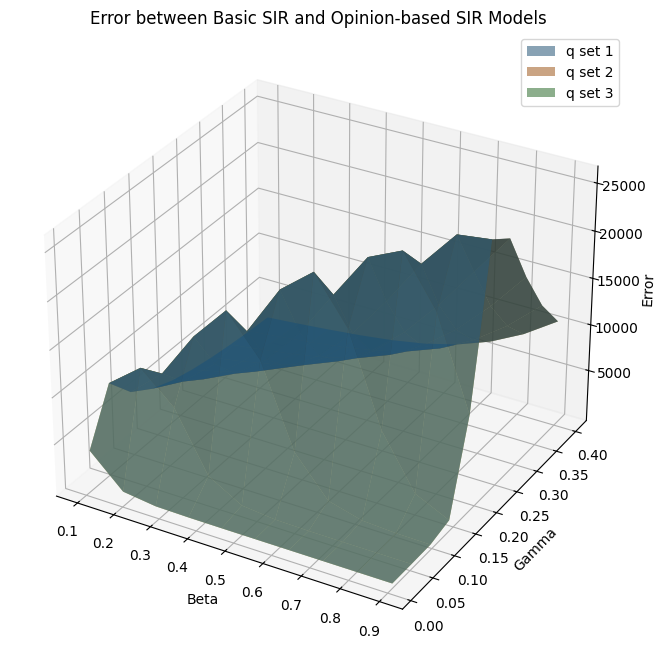

Max error for q set 1: 7779.891087411347
Max error for q set 2: 7777.324490129066
Max error for q set 3: 7776.3804092595765


In [146]:
def diff_beta_gamma_q(init_opinion_state, init_state, steps, q_values, n):
    # Define the range of beta and gamma values for the grid search
    beta_vals = np.linspace(0.1, 0.9, 10)
    gamma_vals = np.linspace(0.01, 0.4, 10)
    errors = np.zeros((len(beta_vals), len(gamma_vals), len(q_values)))

    # Compute the error for each combination of beta, gamma, and q values
    for i, beta_a in enumerate(beta_vals):
        for j, gamma_a in enumerate(gamma_vals):
            for k, q in enumerate(q_values):
                # Simulate the opinion-based SIR model
                populations = simulate_transition(init_opinion_state, beta_a, gamma_a, steps, q)
                
                # Sum the opinion-based model results
                S_opinion = np.array([sum(pop[:n]) for pop in populations])
                I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
                R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])
                
                # Simulate the basic SIR model
                basic_SIR_populations = simulate_basic_SIR(init_state, beta_a, gamma_a, steps)
                S_basic, I_basic, R_basic = zip(*basic_SIR_populations)
                S_basic = np.array(S_basic)
                I_basic = np.array(I_basic)
                R_basic = np.array(R_basic)
                
                # Compute the mean squared error
                error = np.mean((S_opinion - S_basic)**2 + (I_opinion - I_basic)**2 + (R_opinion - R_basic)**2)
                errors[i, j, k] = error

    # Plot the error 3D surface
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    beta_vals, gamma_vals = np.meshgrid(beta_vals, gamma_vals)
    
    for k, q in enumerate(q_values):
        ax.plot_surface(beta_vals, gamma_vals, errors[:, :, k], label=f'q set {k+1}', alpha=0.5)

    ax.set_xlabel('Beta')
    ax.set_ylabel('Gamma')
    ax.set_zlabel('Error')
    plt.title('Error between Basic SIR and Opinion-based SIR Models')
    plt.legend()
    plt.show()

    return errors

# Define a range of q values to test
q_values = [np.array([-9 * i for i in range(n)]), np.array([-10 * i for i in range(n)]), np.array([-11 * i for i in range(n)])]

# Run the analysis for different q values
errors = diff_beta_gamma_q(init_opinion_state, init_state, steps, q_values, n)

# Find and print the maximum error for each set of q values
for k, q in enumerate(q_values):
    max_error = np.mean(errors[:, :, k])
    print(f'Max error for q set {k+1}: {max_error}')